<a href="https://colab.research.google.com/github/rohailkhan/deep_learning/blob/master/0601_Time_Invariant_Face_Rcognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# بسم الله الرحمن الرحيم
اللهم صل على محمد وعلى آل محمد كما صليت على إبراهيم وعلى آل إبراهيم إنك حميد مجيد، اللهم بارك على محمد وعلى آل محمد كما باركت على إبراهيم وعلى آل إبراهيم إنك حميد مجيد




In [1]:
from keras.models import Sequential
"""Import from keras_preprocessing not from keras.preprocessing, 
because Keras may or maynot contain the features discussed here 
depending upon when you read this article, until the keras_
preprocessed library is updated in Keras use the github version."""
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
import os ,PIL
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
# Put all files into a single dataframe
list_dir = [i for i in os.listdir('/content/drive/My Drive/Aging model/datafiles')]
final_df = pd.DataFrame(columns=['ID','Facial Index','Mandibular Index','Intercantal Index','Orbital Width Index','Eye Fissure Index','Vermilion Height Index','Mouth Face Width Index','AGE'])
interim_df = pd.DataFrame(columns=['ID','Facial Index','Mandibular Index','Intercantal Index','Orbital Width Index','Eye Fissure Index','Vermilion Height Index','Mouth Face Width Index','AGE'])
age_list=list()
for d in list_dir:
    interim_df.at[0,  ['Facial Index','Mandibular Index','Intercantal Index','Orbital Width Index','Eye Fissure Index','Vermilion Height Index','Mouth Face Width Index']] = pd.read_csv('/content/drive/My Drive/Aging model/datafiles/'+d, sep=" ", header=None).values[0][:7]
    interim_df['AGE'] = int(d[4:].replace('.txt','').replace('a','').replace('b',''))
    interim_df['ID'] = int(d[:3])
    final_df = pd.concat([final_df,interim_df])
    
# sort values by age of same person
final_df = final_df.sort_values(['ID','AGE'],ascending=True)

In [0]:
final_df.to_csv('/content/drive/My Drive/Aging model/new/final_df.csv',index=False)

# Start

In [0]:
final_df=pd.read_csv('/content/drive/My Drive/Aging model/new/final_df.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
final_df.head(2)

,ID,Facial Index,Mandibular Index,Intercantal Index,Orbital Width Index,Eye Fissure Index,Vermilion Height Index,Mouth Face Width Index,AGE
0,1,0.806070,0.336661,0.390837,0.828399,0.521382,0.599030,0.346350,2
1,1,0.852819,0.442643,0.386980,0.774311,0.461004,0.659254,0.393676,5


In [0]:
# removing the un necessary features
final_df.drop(final_df.columns[[1,2,3,4,5,6,7]], axis = 1, inplace = True) 

In [7]:
final_df.head(3)

,ID,AGE
0,1,2
1,1,5
2,1,8


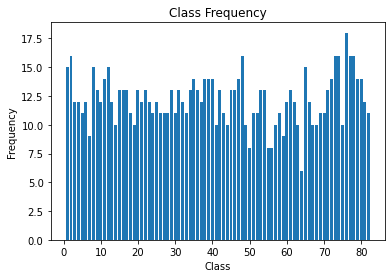

In [8]:
classes=final_df[['ID']].values
unique, counts = np.unique(classes, return_counts=True)
plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [0]:
final_df_1=final_df

# One hot encoding

In [0]:
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([final_df['ID'],pd.get_dummies(final_df['ID'], prefix='person')],axis=1)

In [10]:
df.head(2)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_43,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df.tail(2)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_43,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82
1000,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1001,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
# addng file names
image_names=[]
for i in os.listdir('/content/drive/My Drive/Aging model/fgbw'):
  image_names.append(i)

In [0]:
df['file_name']=image_names

In [13]:
df.head(2)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82,file_name
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,002A03.JPG
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,001A33.JPG


In [14]:
df.tail(2)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82,file_name
1000,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,001A02.JPG
1001,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,001A18.JPG


In [0]:
df.to_csv('/content/drive/My Drive/Aging model/new/df.csv',index=False)

# Read

In [0]:
final_df=df

In [0]:
final_df=pd.read_csv('/content/drive/My Drive/Aging model/new/df.csv')


In [16]:
final_df.tail(2)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82,file_name
1000,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,001A02.JPG
1001,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,001A18.JPG


# Splitting data in training and validation(test) sets

In [0]:
train_size = len(final_df['ID'].unique()) * .8
train = pd.DataFrame()
valid = pd.DataFrame()
for n,i in enumerate(final_df['ID'].unique()):
    if n< train_size:
        train = pd.concat([train, final_df[final_df['ID']==i]])
    else:
        valid = pd.concat([valid, final_df[final_df['ID']==i]])

In [18]:
print('Training Set Has: ' + str(len(train.groupby('ID').count())) + ' people')
print('Validation (Test) Set Has: ' + str(len(valid.groupby('ID').count())) + ' people')

Training Set Has: 66 people
Validation (Test) Set Has: 16 people


In [34]:
train.tail(3)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82,file_name
787,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,066A08.JPG
788,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,067A26.JPG
789,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,067A23.JPG


# creating Test data

In [35]:
np.unique(train.ID.values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66])

In [0]:
# now drop the original 'ID' column (not needed  anymore)
# df.drop(['ID'],axis=1, inplace=True)

In [19]:
 test_ids= [ 34,35, 36, 37, 38, 39, 40, 41] 
# test_ids= [ 34,35] 

  
# selecting rows based on condition 
test= train[train['ID'].isin(test_ids)] 
test.head(3)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82,file_name
404,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,034A25.JPG
405,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,034A21.JPG
406,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,034A16.JPG


In [20]:
test.shape

(104, 2)

In [37]:
train.columns

Index(['ID', 'person_1', 'person_2', 'person_3', 'person_4', 'person_5',
       'person_6', 'person_7', 'person_8', 'person_9', 'person_10',
       'person_11', 'person_12', 'person_13', 'person_14', 'person_15',
       'person_16', 'person_17', 'person_18', 'person_19', 'person_20',
       'person_21', 'person_22', 'person_23', 'person_24', 'person_25',
       'person_26', 'person_27', 'person_28', 'person_29', 'person_30',
       'person_31', 'person_32', 'person_33', 'person_34', 'person_35',
       'person_36', 'person_37', 'person_38', 'person_39', 'person_40',
       'person_41', 'person_42', 'person_43', 'person_44', 'person_45',
       'person_46', 'person_47', 'person_48', 'person_49', 'person_50',
       'person_51', 'person_52', 'person_53', 'person_54', 'person_55',
       'person_56', 'person_57', 'person_58', 'person_59', 'person_60',
       'person_61', 'person_62', 'person_63', 'person_64', 'person_65',
       'person_66', 'person_67', 'person_68', 'person_69', 'person_

In [0]:
# removing 34,35, 36, 37, 38, 39, 40, 41 indices
''' train_ids=['person_1', 'person_2', 'person_3', 'person_4', 'person_5',
       'person_6', 'person_7', 'person_8', 'person_9', 'person_10',
       'person_11', 'person_12', 'person_13', 'person_14', 'person_15',
       'person_16', 'person_17', 'person_18', 'person_19', 'person_20',
       'person_21', 'person_22', 'person_23', 'person_24', 'person_25',
       'person_26', 'person_27', 'person_28', 'person_29', 'person_30',
       'person_31', 'person_32', 'person_33', 'person_42', 'person_43', 'person_44', 'person_45',
       'person_46', 'person_47', 'person_48', 'person_49', 'person_50',
       'person_51', 'person_52', 'person_53', 'person_54', 'person_55',
       'person_56', 'person_57', 'person_58', 'person_59', 'person_60',
       'person_61', 'person_62', 'person_63', 'person_64', 'person_65',
       'person_66', 'person_67', 'person_68', 'person_69', 'person_70',
       'person_71', 'person_72', 'person_73', 'person_74', 'person_75',
       'person_76', 'person_77', 'person_78', 'person_79', 'person_80',
       'person_81', 'person_82'] '''

In [0]:
# removing 34,35, 36, 37, 38, 39, 40, 41 indices
train_ids=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '42', '43', '44', '45', '46', '47',
       '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       '72', '73', '74', '75', '76', '77', '78', '79', '80', '81']

In [21]:
train= train[train['ID'].isin(train_ids)] 
train.head(3)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82,file_name
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,002A03.JPG
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,001A33.JPG
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,001A28.JPG


In [22]:
print('Training Set Has: ' + str(len(train.groupby('ID').count())) + ' people')
print('Validation  Set Has: ' + str(len(valid.groupby('ID').count())) + ' people')
print('Test Set Has: ' + str(len(test.groupby('ID').count())) + ' people')

Training Set Has: 58 people
Validation  Set Has: 16 people
Test Set Has: 8 people


# Target labels

In [41]:
test.columns

Index(['ID', 'person_1', 'person_2', 'person_3', 'person_4', 'person_5',
       'person_6', 'person_7', 'person_8', 'person_9', 'person_10',
       'person_11', 'person_12', 'person_13', 'person_14', 'person_15',
       'person_16', 'person_17', 'person_18', 'person_19', 'person_20',
       'person_21', 'person_22', 'person_23', 'person_24', 'person_25',
       'person_26', 'person_27', 'person_28', 'person_29', 'person_30',
       'person_31', 'person_32', 'person_33', 'person_34', 'person_35',
       'person_36', 'person_37', 'person_38', 'person_39', 'person_40',
       'person_41', 'person_42', 'person_43', 'person_44', 'person_45',
       'person_46', 'person_47', 'person_48', 'person_49', 'person_50',
       'person_51', 'person_52', 'person_53', 'person_54', 'person_55',
       'person_56', 'person_57', 'person_58', 'person_59', 'person_60',
       'person_61', 'person_62', 'person_63', 'person_64', 'person_65',
       'person_66', 'person_67', 'person_68', 'person_69', 'person_

In [0]:
target_columns=['person_1', 'person_2', 'person_3', 'person_4', 'person_5',
       'person_6', 'person_7', 'person_8', 'person_9', 'person_10',
       'person_11', 'person_12', 'person_13', 'person_14', 'person_15',
       'person_16', 'person_17', 'person_18', 'person_19', 'person_20',
       'person_21', 'person_22', 'person_23', 'person_24', 'person_25',
       'person_26', 'person_27', 'person_28', 'person_29', 'person_30',
       'person_31', 'person_32', 'person_33', 'person_34', 'person_35',
       'person_36', 'person_37', 'person_38', 'person_39', 'person_40',
       'person_41', 'person_42', 'person_43', 'person_44', 'person_45',
       'person_46', 'person_47', 'person_48', 'person_49', 'person_50',
       'person_51', 'person_52', 'person_53', 'person_54', 'person_55',
       'person_56', 'person_57', 'person_58', 'person_59', 'person_60',
       'person_61', 'person_62', 'person_63', 'person_64', 'person_65',
       'person_66', 'person_67', 'person_68', 'person_69', 'person_70',
       'person_71', 'person_72', 'person_73', 'person_74', 'person_75',
       'person_76', 'person_77', 'person_78', 'person_79', 'person_80',
       'person_81', 'person_82']

In [25]:
len(target_columns)

82

In [0]:
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU

act = LeakyReLU(alpha=0.3)

# Why I am using Binary Cross Entropy
### Binary cross-entropy is for multi-label classifications, whereas categorical cross entropy is for multi-class classification where each example belongs to a single class.

### There are three kinds of classification tasks:

    Binary classification: two exclusive classes
    Multi-class classification: more than two exclusive classes
    Multi-label classification: just non-exclusive classes

Here, we can say

    In the case of (1), you need to use binary cross entropy.
    In the case of (2), you need to use categorical cross entropy.
    In the case of (3), you need to use binary cross entropy.

https://stats.stackexchange.com/questions/260505/should-i-use-a-categorical-cross-entropy-or-binary-cross-entropy-loss-for-binary 

# Model 8 simple

In [0]:
#Experiment 1..Safa-141..n0
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

#dropout just before the dense layer
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))


model.add(Dense(82, activation='softmax'))

model.compile(loss='binary_crossentropy',
optimizer=optimizers.Adam(lr=1e-4),
metrics=['acc'])

In [0]:
#Experiment 1..Safa-141..just change the relu to simgoid..no
#Experiment 1..Safa-141
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='sigmoid',
input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(64, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(128, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

#dropout just before the dense layer
model.add(Dropout(0.5))
model.add(Dense(512, activation='sigmoid'))


model.add(Dense(82, activation='softmax'))

model.compile(loss='binary_crossentropy',
optimizer=optimizers.Adam(lr=1e-4),
metrics=['acc'])

In [0]:
# adding regularization
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU

In [0]:
act = LeakyReLU(alpha=0.2)

In [0]:
## Alhamdulillah...
# Model 1 with leay relu, softmax and binary cross entropy
model3 =Sequential()

model3.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model3.add(act)
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(64, (3, 3)))
model3.add(act)
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.02), bias_regularizer=l2(0.02)))
model3.add(Conv2D(128, (3, 3)))
model3.add(act)
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(128, (3, 3)))
model3.add(act)

model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dropout(0.2))
model3.add(Dense(512))
model3.add(act)
model3.add(Dense(82, activation='sigmoid'))
model3.compile(loss='binary_crossentropy',
optimizer=optimizers.Adam(lr=1e-6),
metrics=['accuracy'])

In [0]:
## Alhamdulillah...
# SVM model
model3 =Sequential()
#Layer 1
model3.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model3.add(act)
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))

#Layer 2
model3.add(Conv2D(64, (3, 3)))
model3.add(act)
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
#model3.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.02), bias_regularizer=l2(0.02)))

#Layer 3
model3.add(Conv2D(128, (3, 3)))
model3.add(act)
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))

#model3.add(Conv2D(128, (3, 3)))
#model3.add(act)
#model3.add(MaxPooling2D((2, 2)))

model3.add(Flatten())
#model3.add(Dropout(0.2))
model3.add(Dense(512))
model3.add(act)
#model3.add(Dropout(0.5))
model3.add(Dense(82, activation='linear'))


model3.compile(loss='hinge',
optimizer=optimizers.Adadelta(lr=1e-6),
metrics=['accuracy'])

In [0]:
## Alhamdulillah...
# SVM model..with relu
model3 =Sequential()
#Layer 1
model3.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))

#Layer 2
model3.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
#model3.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.02), bias_regularizer=l2(0.02)))

#Layer 3
model3.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))

#model3.add(Conv2D(128, (3, 3)))
#model3.add(act)
#model3.add(MaxPooling2D((2, 2)))

model3.add(Flatten())
model3.add(Dropout(0.2))
model3.add(Dense(512))
model3.add(act)
#model3.add(Dropout(0.5))
model3.add(Dense(82, activation='linear'))


model3.compile(loss='hinge',
optimizer=optimizers.Adadelta(lr=1e-6),
metrics=['accuracy'])

# **Defining** Train ,Validation and Test generator

## First doing Face Augmentation only for the Train Data

In [0]:
## Defining Augmentation object using ImageDataGenerator
TRAIN_DATAGEN = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,)

In [34]:
train_generator=TRAIN_DATAGEN.flow_from_dataframe(
dataframe=train,
directory="/content/drive/My Drive/Aging model/fgbw",
x_col='file_name',
y_col=target_columns,
batch_size=32,
seed=42,
shuffle=True,class_mode='raw',
target_size=(150,150))

Found 686 validated image filenames.


In [35]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=valid,
directory="/content/drive/My Drive/Aging model/fgbw",
x_col='file_name',
y_col=target_columns,
batch_size=32,
seed=42,
shuffle=True,class_mode='raw',
target_size=(150,150))

Found 212 validated image filenames.


In [36]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator=valid_datagen.flow_from_dataframe(
dataframe=test,
directory="/content/drive/My Drive/Aging model/fgbw",
x_col='file_name',
y_col=target_columns,
batch_size=32,
seed=42,
shuffle=True,class_mode='raw',
target_size=(150,150))

Found 104 validated image filenames.


# Training begins Experiment 1 (model 1)

In [64]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history =model3.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

Epoch 1/20
21/21 [==============================] - 6s 304ms/step - loss: 1.5406 - accuracy: 0.5360 - val_loss: 1.5404 - val_accuracy: 0.5751
Epoch 2/20
21/21 [==============================] - 6s 294ms/step - loss: 1.5321 - accuracy: 0.5810 - val_loss: 1.5372 - val_accuracy: 0.6104
Epoch 3/20
21/21 [==============================] - 6s 299ms/step - loss: 1.5236 - accuracy: 0.6258 - val_loss: 1.5338 - val_accuracy: 0.6472
Epoch 4/20
21/21 [==============================] - 6s 278ms/step - loss: 1.5154 - accuracy: 0.6627 - val_loss: 1.5305 - val_accuracy: 0.6816
Epoch 5/20
21/21 [==============================] - 6s 280ms/step - loss: 1.5065 - accuracy: 0.6969 - val_loss: 1.5271 - val_accuracy: 0.7160
Epoch 6/20
21/21 [==============================] - 6s 279ms/step - loss: 1.4973 - accuracy: 0.7290 - val_loss: 1.5220 - val_accuracy: 0.7424
Epoch 7/20
21/21 [==============================] - 6s 277ms/step - loss: 1.4873 - accuracy: 0.7560 - val_loss: 1.5196 - val_accuracy: 0.7699
Epoch 

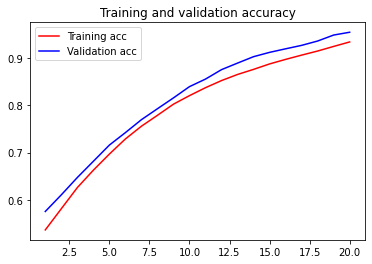

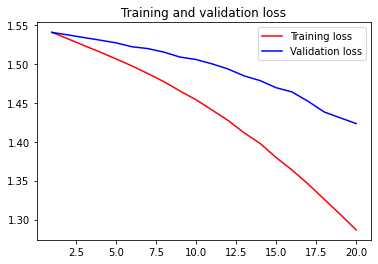

In [65]:
#MAY 30 am
### FINAL Alhamdulillah...use sigmoid with binary-entropy...
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Evaluate model with the unseen data

In [68]:
score=model3.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.4363341331481934
Test accuracy: 0.9552063345909119


In [69]:
model3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    multiple                  0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 36, 36, 64)      

# Better model is model 4 but not best model

In [0]:
## Alhamdulillah...
# Model 1 with leay relu, softmax and binary cross entropy
model4 =Sequential()

model4.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model4.add(act)
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(64, (3, 3)))
model4.add(act)
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.02), bias_regularizer=l2(0.02)))
model4.add(Conv2D(128, (3, 3)))
model4.add(act)
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(128, (3, 3)))
model4.add(act)

model4.add(MaxPooling2D((2, 2)))
model4.add(Flatten())
model4.add(Dropout(0.2))
model4.add(Dense(512))
model4.add(act)
model4.add(Dense(82, activation='sigmoid'))
model4.compile(loss='binary_crossentropy',
optimizer=optimizers.Adam(lr=1e-6),
metrics=['accuracy'])

In [73]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history =model4.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

Epoch 1/20
21/21 [==============================] - 6s 303ms/step - loss: 1.5596 - accuracy: 0.5197 - val_loss: 1.5554 - val_accuracy: 0.5390
Epoch 2/20
21/21 [==============================] - 6s 298ms/step - loss: 1.5511 - accuracy: 0.5608 - val_loss: 1.5523 - val_accuracy: 0.5842
Epoch 3/20
21/21 [==============================] - 6s 286ms/step - loss: 1.5427 - accuracy: 0.6003 - val_loss: 1.5489 - val_accuracy: 0.6285
Epoch 4/20
21/21 [==============================] - 6s 278ms/step - loss: 1.5342 - accuracy: 0.6371 - val_loss: 1.5461 - val_accuracy: 0.6709
Epoch 5/20
21/21 [==============================] - 6s 276ms/step - loss: 1.5251 - accuracy: 0.6729 - val_loss: 1.5421 - val_accuracy: 0.7147
Epoch 6/20
21/21 [==============================] - 6s 284ms/step - loss: 1.5156 - accuracy: 0.7094 - val_loss: 1.5381 - val_accuracy: 0.7508
Epoch 7/20
21/21 [==============================] - 6s 284ms/step - loss: 1.5063 - accuracy: 0.7412 - val_loss: 1.5344 - val_accuracy: 0.7717
Epoch 

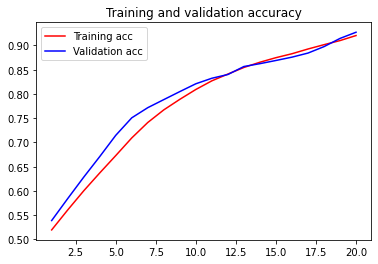

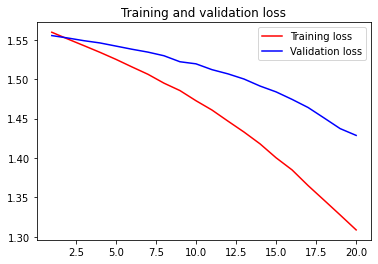

In [74]:
#MAY 30 am
### FINAL Alhamdulillah...use sigmoid with binary-entropy...
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [75]:
score=model3.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.4033362865447998
Test accuracy: 0.965056300163269


# Model4 from Model4 without regularization=0.01

In [0]:
## Alhamdulillah...
# Model 1 with leay relu, softmax and binary cross entropy
model5 =Sequential()

model5.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model5.add(act)
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(64, (3, 3)))
model5.add(act)
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model5.add(Conv2D(128, (3, 3)))
model5.add(act)
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(128, (3, 3)))
model5.add(act)

model5.add(MaxPooling2D((2, 2)))
model5.add(Flatten())
model5.add(Dropout(0.2))
model5.add(Dense(512))
model5.add(act)
model5.add(Dense(82, activation='sigmoid'))
model5.compile(loss='binary_crossentropy',
optimizer=optimizers.Adam(lr=1e-6),
metrics=['accuracy'])

In [77]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history =model5.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

Epoch 1/20
21/21 [==============================] - 7s 315ms/step - loss: 1.1249 - accuracy: 0.4543 - val_loss: 1.1193 - val_accuracy: 0.4914
Epoch 2/20
21/21 [==============================] - 6s 295ms/step - loss: 1.1197 - accuracy: 0.5006 - val_loss: 1.1172 - val_accuracy: 0.5714
Epoch 3/20
21/21 [==============================] - 6s 276ms/step - loss: 1.1143 - accuracy: 0.5575 - val_loss: 1.1149 - val_accuracy: 0.6484
Epoch 4/20
21/21 [==============================] - 6s 275ms/step - loss: 1.1091 - accuracy: 0.6092 - val_loss: 1.1132 - val_accuracy: 0.7020
Epoch 5/20
21/21 [==============================] - 6s 281ms/step - loss: 1.1036 - accuracy: 0.6568 - val_loss: 1.1105 - val_accuracy: 0.7529
Epoch 6/20
21/21 [==============================] - 6s 279ms/step - loss: 1.0975 - accuracy: 0.7054 - val_loss: 1.1082 - val_accuracy: 0.7825
Epoch 7/20
21/21 [==============================] - 6s 273ms/step - loss: 1.0911 - accuracy: 0.7423 - val_loss: 1.1060 - val_accuracy: 0.8172
Epoch 

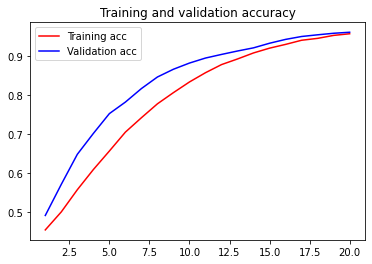

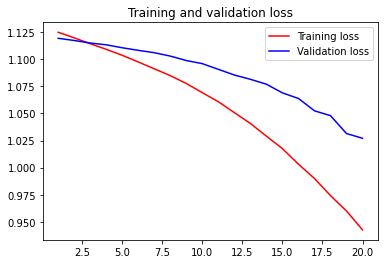

In [78]:
#MAY 30 am
### FINAL Alhamdulillah...use sigmoid with binary-entropy...
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [80]:
score=model5.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.041076421737671
Test accuracy: 0.9608348608016968


# using same above model with some changes in Layers

# The best Model 6

In [0]:
# adding regularization
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
act = LeakyReLU(alpha=0.1)

In [0]:
## Alhamdulillah...

model6 =Sequential()

model6.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(64, (3, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(62, (3,3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(128, (3, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(128, (3, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))

model6.add(Flatten())
model6.add(Dropout(0.2))
model6.add(Dense(512))
model6.add(act)
model6.add(Dense(82, activation='sigmoid'))

model6.compile(loss='binary_crossentropy',
optimizer=optimizers.Adam(lr=1e-5),
metrics=['accuracy'])


In [109]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history =model6.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

Epoch 1/20
21/21 [==============================] - 6s 304ms/step - loss: 1.3182 - accuracy: 0.5272 - val_loss: 1.3143 - val_accuracy: 0.5992
Epoch 2/20
21/21 [==============================] - 6s 292ms/step - loss: 1.2976 - accuracy: 0.6150 - val_loss: 1.3045 - val_accuracy: 0.7458
Epoch 3/20
21/21 [==============================] - 6s 275ms/step - loss: 1.2732 - accuracy: 0.6976 - val_loss: 1.2918 - val_accuracy: 0.8100
Epoch 4/20
21/21 [==============================] - 6s 285ms/step - loss: 1.2387 - accuracy: 0.7657 - val_loss: 1.2722 - val_accuracy: 0.8801
Epoch 5/20
21/21 [==============================] - 6s 274ms/step - loss: 1.1860 - accuracy: 0.8293 - val_loss: 1.2442 - val_accuracy: 0.9058
Epoch 6/20
21/21 [==============================] - 6s 275ms/step - loss: 1.1096 - accuracy: 0.8803 - val_loss: 1.1928 - val_accuracy: 0.9541
Epoch 7/20
21/21 [==============================] - 6s 273ms/step - loss: 1.0072 - accuracy: 0.9233 - val_loss: 1.1208 - val_accuracy: 0.9656
Epoch 

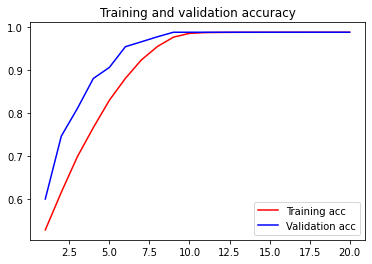

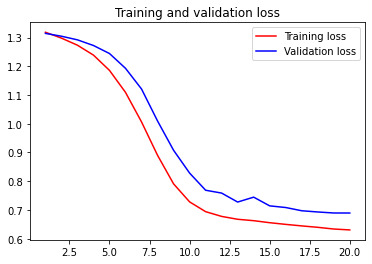

In [110]:
#MAY 30 am
### FINAL Alhamdulillah...use sigmoid with binary-entropy...
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Evaluating on un seen data

In [111]:
score=model6.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7223640084266663
Test accuracy: 0.9878048300743103
